# Problem 3: Does dark energy exist?

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy import optimize
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import Planck18
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm

In [2]:
dtype = {
    'names': ['name', 'z', 'mb', 'e_mb', 'x1', 'e_x1', 'c', 'e_c'],
    'formats': ['U10'] + ['<f8']*7
}

arr = np.genfromtxt('exercise3_supernova_data.dat', skip_header=49, dtype=dtype)
data = pd.DataFrame(arr)
data

,name,z,mb,e_mb,x1,e_x1,c,e_c
0,03D1au,0.503,23.002,0.088,1.273,0.150,-0.012,0.030
1,03D1aw,0.581,23.574,0.090,0.974,0.274,-0.025,0.037
2,03D1ax,0.495,22.960,0.088,-0.729,0.102,-0.100,0.030
3,03D1bp,0.346,22.398,0.087,-1.155,0.113,-0.041,0.027
4,03D1co,0.678,24.078,0.098,0.619,0.404,-0.039,0.067
...,...,...,...,...,...,...,...,...
735,sn2007co,0.027,16.504,0.142,-0.138,0.061,0.105,0.020
736,sn2007cq,0.025,15.798,0.143,-0.658,0.116,-0.061,0.026
737,sn2007f,0.024,15.896,0.144,0.619,0.041,-0.055,0.026
738,sn2007qe,0.024,16.068,0.144,0.761,0.046,0.052,0.026


First we implement following functions:

The measured apparent magnitude, corrected for stretch and color of the corresponding lightcurve:
$$
m_{meas}(\alpha, \beta) = m_b + x_1 \cdot \alpha - c \cdot \beta
$$

The error on $m_{meas}$
$$
e_{m,meas}(\alpha, \beta, \sigma_{int}) = \sqrt{e_{m,b}^2 + (e_{x,1} \cdot \alpha)^2 + (e_c \cdot \beta)^2 + \sigma_{int}^2}
$$

The luminosity distance derived from the measurements and its uncertainty:
$$
\begin{array}\\
d_{L, meas}(\alpha, \beta, \sigma_{int}, M_0) &=& 10^{(m_{meas}(c, \alpha, \beta) - M_0)/5} \cdot 10\, \mathrm{pc} \\
e_{d_L, meas}(\alpha, \beta, \sigma_{int}, M_0) &=& 10^{ (m_{meas}(c, \alpha, \beta) - M_0)/ 5} \cdot \frac{\ln(10)}{5} \cdot e_{m,meas}(\alpha, \beta, \sigma_{int}) \cdot 10 \, \mathrm{pc}
\end{array}
$$

The luminosity distance predicted by the cosmological model:
$$
d_{L, model}(z, \Omega_M, \Omega_\Lambda) = (1+z) \frac{c}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_M (1+z')^3 + \Omega_\Lambda}}
$$

In [3]:
def m_meas(mb, x1, c, alpha, beta):
    return mb + x1 * alpha - c * beta


def e_m_meas(e_mb, e_x1, e_c, alpha, beta, sigma):
    return np.sqrt(e_mb**2 + (alpha * e_x1)**2 + (beta * e_c)**2 + sigma**2)


def luminosity_distance_from_measurement(data, alpha, beta, M0, sigma):
    m = m_meas(data.mb, data.x1, data.c, alpha, beta)
    mu = m - M0
    dl = 10 ** (mu / 5) * 10*u.pc
    
    e_m = e_m_meas(data.e_mb, data.e_x1, data.e_c, alpha, beta, sigma)
    e_dl = np.sqrt((np.exp(mu / 5 * np.log(10)) * np.log(10) / 5 * 10 * e_m)**2) * u.pc
    
    return u.Quantity(dl), u.Quantity(e_dl)


def luminosity_distance(z, omega_M, omega_L, unit='Mpc'):
    
    def integrand(zprime):
        return 1 / np.sqrt(omega_M * (1 + zprime)**3 + omega_L)
    
    integral = list()
    for iz in np.atleast_1d(z):
        i_integral, i_err = quad(integrand, 0, iz)
        integral.append(i_integral)
        
    dl = (1 + np.array(z)) * const.c.to(f'{unit} s-1') / Planck18.H0.to('s-1') * np.array(integral)
    return u.Quantity(dl)

i) During the lecture we identified a set of potential systematic effects which would explain why distant supernovae look dimmer than expected without invoving dark energy. These included
* a continous distribution of dust in the intergalactic medium, 
* evolution of supernova properties with time and 
* instrument non-linearities between bright/faind and red/blue objects. 

Can you think of tests or additional experiments that could be used to rule-out or confirm these systematics?
* Dust should also redden the spectrum. If dust is the only systematic we should observe this reddening along with the dimmer lightcurves
* 
* Instrument effects can be investigated by calibration devices e.g. lamps

ii) Compare the relative probabilities / likelihoods of a LCDM universe $(\Omega_M , \Omega_{DE} = 0.3,0.7)$ with one with only matter $(\Omega_M , \Omega_{DE} = 0.3,0.0)$ . Is dark energy needed?

We will use $\chi^2$ as a measure of the deviation of our data from the model.
$$
\chi^2 = \frac{1}{2} \sum_i \frac{(d_{L,meas,i} - d_{L,model,i})^2}{e_{d_L, meas,i}^2}
$$.
The lower the $\chi^2$ value the better the data fits to the model.

In [8]:
def chi2(data, omega_M, omega_L, alpha, beta, M0, sigma):
    dl_meas, edl_meas = luminosity_distance_from_measurement(data, alpha, beta, M0, sigma)
    dl_model = luminosity_distance(data.z, omega_M, omega_L)
    
    residuals_squared = (dl_meas - dl_model) ** 2
    weights = edl_meas ** 2
    single_chi2 = residuals_squared / weights
    return 0.5 * np.sum(single_chi2)

In [7]:
alpha, beta, M0 = 0.15, 3, -19
sigma = 0.14

dm_chi2 = chi2(data, 0.3, 0.7, alpha, beta, M0, sigma)
nodm_chi2 = chi2(data, 0.3, 0, alpha, beta, M0, sigma)

print(f"Chi2 for model with dark energy: {dm_chi2:.2f}")
print(f"Chi2 for model without dark energy: {nodm_chi2:.2f}")

Chi2 for model with dark energy: 420.00
Chi2 for model without dark energy: 22170.23


Obviously we do need dark energy!

iii) Find the best fit values of $(\Omega_M , \Omega_{DE})$ assuming fixed values for nuisance parameters $(\alpha, \beta, M_0 = 0.15, 3, -19)$

We just need a little helper function that takes one argument that will include the values for $\Omega_M$ and $\Omega_\Lambda$ and returns the corresponding $\chi^2$ value. That function can then be minimised.

In [13]:
alpha, beta, M0 = 0.15, 3, -19
sigma = 0.14

def minfunc(args):
    omega_M, omega_L = args
    return chi2(data, omega_M, omega_L, alpha, beta, M0, sigma)

res = optimize.minimize(minfunc, bounds=[(0, 1), (0, 1)], x0=[0.5, 0.1])

print(f'best fit: \n omega_M: {res.x[0]:.2f} \n omega_L: {res.x[1]:.2f} \n chi2: {res.fun:.2f}')

dl_meas, edl_meas = luminosity_distance_from_measurement(data, alpha, beta, M0, sigma)
z_plot = np.linspace(0, data.z.max(), 100)
dl_best_fit = luminosity_distance(z_plot, *res.x)

best fit: 
 omega_M: 0.33 
 omega_L: 0.85 
 chi2: 191.36


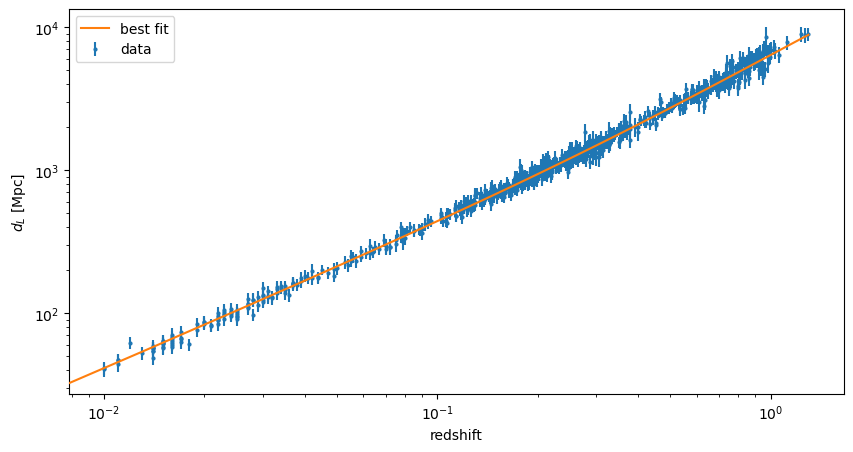

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

dl_unit = 'Mpc'
ax.errorbar(data.z, dl_meas.to(dl_unit).value, yerr=edl_meas.to(dl_unit).value, 
            ls='', marker='o', capsize=0, ms=2, label='data')
ax.plot(z_plot, dl_best_fit, label='best fit', zorder=5)

ax.set_ylabel(f'$d_L$ [{dl_unit}]')
ax.set_xlabel('redshift')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.show()
plt.close()

iv) Find the best fit values of $(\Omega_M , \Omega_{DE})$ while also fitting (and marginalizing over) the nuisance parameters $(\alpha, \beta, M_0)$. The real values are similar but not identical to the ones used above.

We will find the best fit parameters here. An exursus on how to do the marginalisation correctly can be found at the end of the notebook if you are interested.

In [15]:
def log_likelihood(theta):
    omega_M, omega_L, alpha, beta, M0 = theta
    return chi2(data, omega_M, omega_L, alpha, beta, M0, sigma)

In [16]:
bounds = [(0, 1), (0, 1), (-5, 5), (-5, 5), (-25, 0)]

best_fit = optimize.minimize(
    log_likelihood, 
    x0=[0.3, 0.7, 0.15, 3, -19], 
    bounds=bounds
)

print("----- best fit parameters -----")
param_names = ['Omega_M', 'Omega_L', 'alpha', 'beta', 'M0']
for n, val in zip(param_names, best_fit.x):
    print(f"\t{n:<7} = {val:.2f}")

best_om, best_ol, best_a, best_b, best_m = best_fit.x
dl_meas, edl_meas = luminosity_distance_from_measurement(data, best_a, best_b, best_m, sigma)
dl_model = luminosity_distance(z_plot, best_om, best_ol)

----- best fit parameters -----
	Omega_M = 0.32
	Omega_L = 0.76
	alpha   = 0.13
	beta    = 2.90
	M0      = -19.09


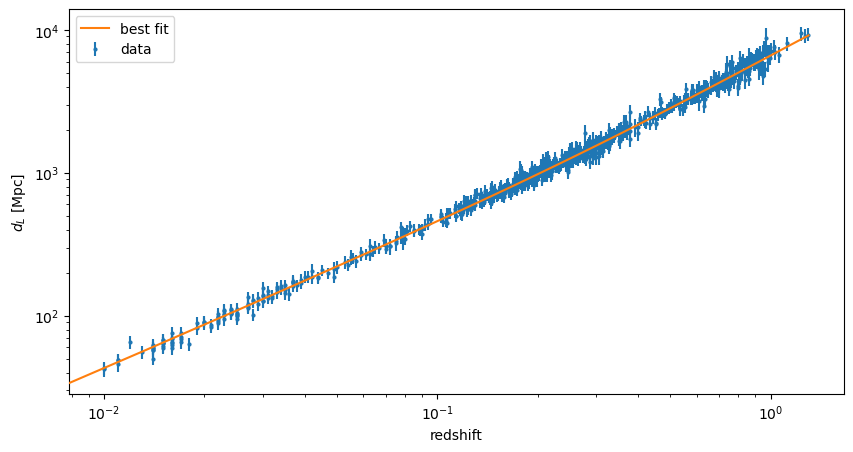

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

dl_unit = 'Mpc'
ax.errorbar(data.z, dl_meas.to(dl_unit).value, yerr=edl_meas.to(dl_unit).value, 
            ls='', marker='o', capsize=0, ms=2, label='data')
ax.plot(z_plot, dl_model, label='best fit', zorder=5)

ax.set_ylabel(f'$d_L$ [{dl_unit}]')
ax.set_xlabel('redshift')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.show()
plt.close()

v) Create your own map showing probability countours ($\Delta \chi^2$) in the $(\Omega_M , \Omega_{DE})$ plain.

What we want to do is to create a grid in the ($\Omega_M$, $\Omega_\Lambda$) plain. For each grid point we the evaluate our $\chi^2$. We could create an array that holds lists, representing the rows or columns on the grid and manually loop through the values on the plain. As this a task that is often used, there is - of course - a convenient implementation for this:

In [11]:
x0, fval, grid, Jout = optimize.brute(minfunc, ranges=[(1e-2, 1), (1e-2, 1)], full_output=True)

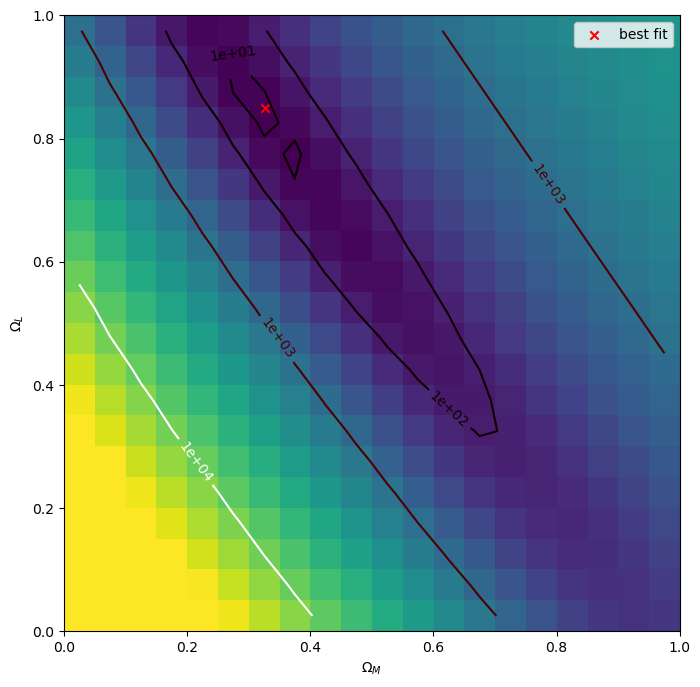

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(Jout.T, origin='lower', extent=[0, 1, 0, 1], norm=LogNorm(vmin=190, vmax=30000))
ax.scatter(*x0, marker='x', color='r', label='best fit')
cs = ax.contour(Jout.T - fval, origin='lower', extent=[0, 1, 0, 1], levels=[10, 100, 1000, 10000], cmap='hot')
ax.clabel(cs, cs.levels, inline=True, fontsize=10, fmt='%.0e')
ax.legend()
ax.set_xlabel("$\Omega_M$")
ax.set_ylabel("$\Omega_L$")
plt.show()
plt.close()

If we want to have a closer look around the best fit position we just adjust our grid

In [13]:
x0_zoom, fval_zoom, grid_zoom, Jout_zoom = optimize.brute(minfunc, ranges=[(0.2, 0.4), (0.75, 0.95)], full_output=True)

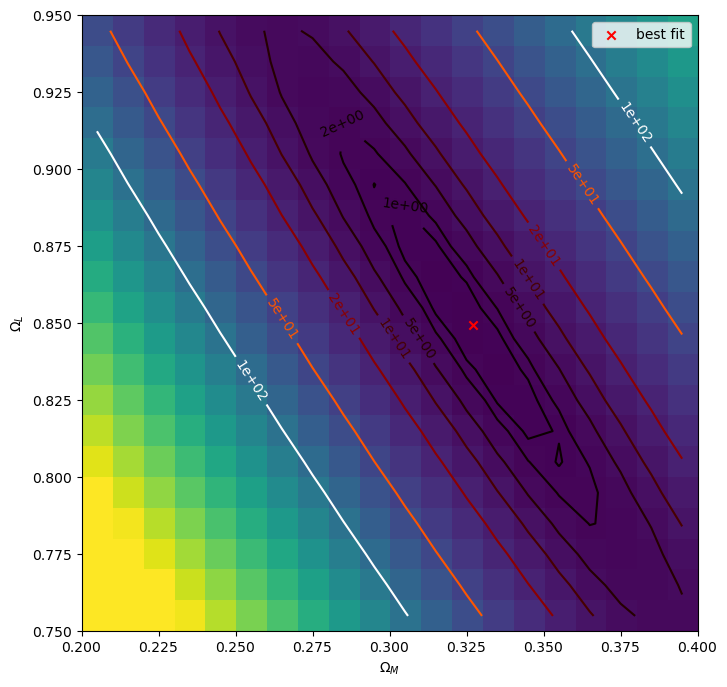

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(Jout_zoom.T, origin='lower', extent=[0.2, 0.4, 0.75, 0.95], norm=LogNorm(vmin=190, vmax=600))
ax.scatter(*x0_zoom, marker='x', color='r', label='best fit')
cs = ax.contour(Jout_zoom.T - fval_zoom, origin='lower', extent=[0.2, 0.4, 0.75, 0.95], levels=[1, 2, 5, 10, 20, 50, 100], cmap='hot')
ax.clabel(cs, cs.levels, inline=True, fontsize=10, fmt='%.0e')
ax.legend()
ax.set_xlabel("$\Omega_M$")
ax.set_ylabel("$\Omega_L$")
plt.show()
plt.close()

# EXTRA: Marginalising using MCMC

What you would really do when you want to explore a multi-dimensional likelihood space where you are only interested in some of the parameters is sampling the parameter space with a technique called Markov-Chain Monte Carlo (MCMC). The idea is that the algorithm will jump around in the parameter space and map out the likelihood landscape and what we get are posterior distributions for the parameters. These give us information about the probability of the parameter values given the data. There are a lot of implementations. One of the widely used python packages is [emcee](https://emcee.readthedocs.io/en/stable/). The [accompanying paper](https://arxiv.org/pdf/1202.3665.pdf) also gives a good overview over what MCMC can do for you.

If you want to run the notebook from here on make sure you have the file `exercise3_3_mcmc.h5`.

In [15]:
import emcee

To allow emcee to asses the likelihood of any given point in the parameter space we have to define a likelihood function that takes our parameters $\theta$ as arguments. As is often the case we instead define the negative logarithm of the likelihood:

$$
-\log L(\theta) = \frac{1}{2} \sum \frac{[d_{L, measured}(\theta) - d_{L, model}(\theta)]^2}{\sigma_{measured}(\theta)^2} 
$$

In [16]:
def log_likelihood(theta):
    omega_M, omega_L, alpha, beta, M0 = theta
    
    dl_meas, edl_meas = luminosity_distance_from_measurement(data, alpha, beta, M0, sigma=0.14)
    dl_model = luminosity_distance(data.z, omega_M, omega_L)
    
    residuals_squared = (dl_meas - dl_model) ** 2
    weights = edl_meas ** 2
    unit = 'Mpc 2'
    return 0.5 * np.sum(residuals_squared.to(unit).value / weights.to(unit).value)

As we have done before we can find the best fit parameters by minimising the negative log-likelihood:

In [17]:
bounds = [(0, 1), (0, 1), (0, 5), (0, 5), (-25, 0)]

best_fit = optimize.minimize(
    log_likelihood, 
    x0=[0.3, 0.7, 0.15, 3, -19], 
    bounds=bounds
)

print("----- best fit parameters -----")
param_names = ['Omega_M', 'Omega_L', 'alpha', 'beta', 'M0']
for n, val in zip(param_names, best_fit.x):
    print(f"\t{n:<7} = {val:.2f}")

best_om, best_ol, best_a, best_b, best_m = best_fit.x
dl_meas, edl_meas = luminosity_distance_from_measurement(data, best_a, best_b, best_m, sigma)
dl_model = luminosity_distance(z_plot, best_om, best_ol)

----- best fit parameters -----
	Omega_M = 0.31
	Omega_L = 0.76
	alpha   = 0.13
	beta    = 2.90
	M0      = -19.10


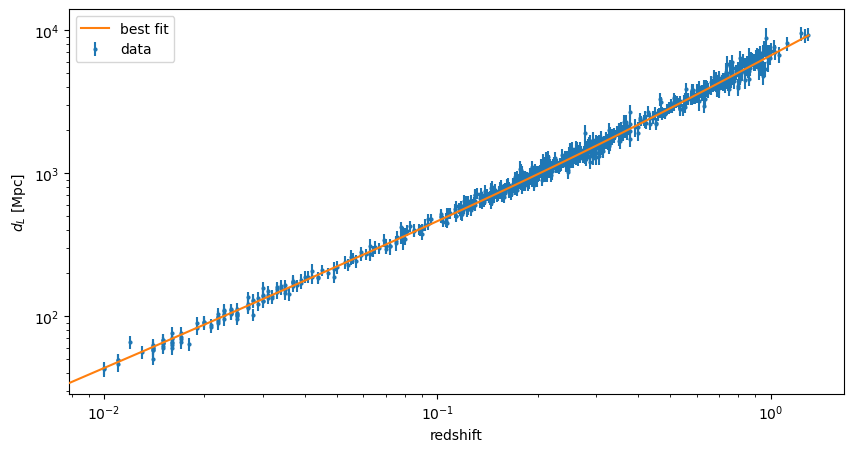

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

dl_unit = 'Mpc'
ax.errorbar(data.z, dl_meas.to(dl_unit).value, yerr=edl_meas.to(dl_unit).value, 
            ls='', marker='o', capsize=0, ms=2, label='data')
ax.plot(z_plot, dl_model, label='best fit', zorder=5)

ax.set_ylabel(f'$d_L$ [{dl_unit}]')
ax.set_xlabel('redshift')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.show()
plt.close()

The power of MCMC hits when we are interested in more than just the best fit parameters. What are the errors on these parameters? Are they correlated? What is the error on our model? etc etc

MCMC is a Bayesian method and as such let's us include prior knowledge about the probability distribution of our parameters. We will use what is known as flat or uninformative priors: we do not have any other info other than the bounds of our parameters. We again define the logarithm of the prior functions

$$
\log p(\theta_i) = \left\{
                    \begin{array}\\
                        0 & \mbox{if } \theta_{i,min} < \theta_i < \theta_{i,max} \\
                        -\inf & \mbox{else.}
                    \end{array}
                   \right.
$$.

The log-probability function is then
$$
\log P(\theta) = \log p(\theta) + \log L(\theta)
$$.

In [19]:
def log_prior(theta):
    omega_M, omega_L, alpha, beta, M0 = theta
    
    check_bounds = [
        b[0] < v < b[1] for v, b in zip(theta, bounds)
    ]
    
    if np.all(check_bounds):
        return 0.
    else:
        return -np.inf


def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - log_likelihood(theta)

What's done next looks a bit technical but what happens is that we pass the log-probability function to the emcee object `sampler` and let it explore the likelihood landscape. This will map out the parameter space and yield the parameter distributions we are lookinf for.

Note: This can take a long time and I have pre-computed everyting and results are saved. Keep the variable `COMPUTE` set to `False` to load these results.

In [20]:
filename = "exercise3_3_mcmc.h5"
backend = emcee.backends.HDFBackend(filename, name='mcmc_vary_nuisance_params')
COMPUTE = False

if COMPUTE:
    import multiprocessing as mp
    mp.set_start_method('fork')

    pos = best_fit.x + 1e-3 * np.random.randn(10, 5)
    nwalkers, ndim = pos.shape
    
    max_n = 100000

    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf
    
    move = emcee.moves.StretchMove(a=80.0)
    new_run = True
    
    with mp.Pool(6) as p:
        
        if new_run:
            backend.reset(nwalkers, ndim)
            state = pos
        else:
            print(f"found {backend.iteration} iterations")
            state = backend.get_last_sample()
            input("correct?")
            
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, pool=p, backend=backend, moves=move
        )

        # Now we'll sample for up to max_n steps
        # we will only keep every 100th step to reduce memory consumption
        thin_by = 100
        for sample in sampler.sample(state, iterations=max_n, progress=True, tune=True, thin_by=thin_by):
            # Only check convergence every 100 steps
            if sampler.iteration % (100/thin_by):
                continue

            # Compute the autocorrelation time so far
            # Using tol=0 means that we'll always get an estimate even
            # if it isn't trustworthy
            tau = sampler.get_autocorr_time(tol=0)
            autocorr[index] = np.mean(tau)
            index += 1

            # Check convergence
            eps = np.abs(old_tau - tau) / tau
            if not sampler.iteration % (1000/thin_by):
                # every 1000 steps print the improvement of tau
                print('median tau improvement :', np.median(eps))
                print('median tau: ', np.median(tau))
                
            converged = np.all(tau * 100 < sampler.iteration)
            converged &= np.all(eps < 0.01)
            if converged:
                break
            old_tau = tau
    
else:
    sampler = backend
    ndim = 5

Let's now look at what the `sampler` has done. `emcee` uses multiple walkers that simultaniously are exploring the parameter space. The following plot shows their "path" through the 5-dimensional space.

Text(0.5, 0, 'step number')

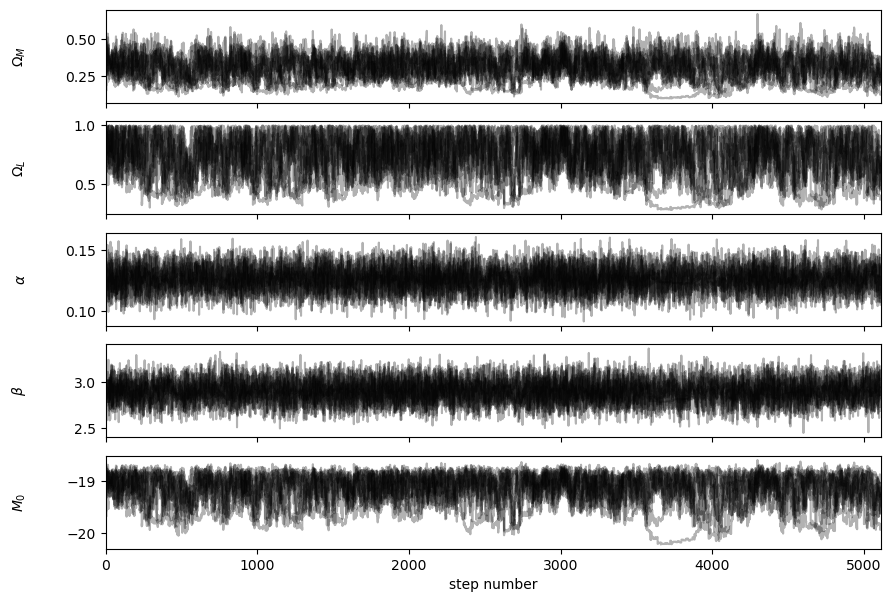

In [21]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\Omega_M$", "$\Omega_L$", r"$\alpha$", r"$\beta$", "$M_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

We can see some straight lines. This means that the algorithm gets stuck in certain areas of the parameter space. This is bad because we want to explore the whole area of possible values. To quantify this we can calculate the auto-correlation time $\tau$. It gives an estimate of how many steps the algorithm has to take to "forget" a previous state.

In [22]:
tau = sampler.get_autocorr_time()
for l, t in zip(param_names, tau):
    print(f"{l}'s tau: {t:.2f}")

Omega_M's tau: 57.76
Omega_L's tau: 58.70
alpha's tau: 12.11
beta's tau: 13.08
M0's tau: 69.16


The message gives us an estimate of the autocorrelaion time. This is an estimate of the number of steps we have to make in the MCMC to get to an uncorrelated state. We see that this length is about 70 for $M_0$

Now we combine all walkers but we discard the first 100 steps and only keep every 70th step to try to have no correlated steps. We are left with 710 steps.

In [23]:
flat_samples = sampler.get_chain(discard=100, thin=70, flat=True)
flat_samples.shape

(710, 5)

For any redshift value we can now calculate the luminosity distance that is predicted by any of the model realisations we have saved. From that distribution we can calculate the 90% confidence interval which gives us a nice error band on our best-fit model.

In [24]:
errors = list()
cl = 0.9
for z in tqdm(z_plot):
    dls = [luminosity_distance(z, *omegas) for omegas in flat_samples[:, :2]]
    ci = np.quantile(dls, [0.5-cl/2, 0.5+cl/2])
    errors.append(ci)
    
errors = np.array(errors)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.59it/s]


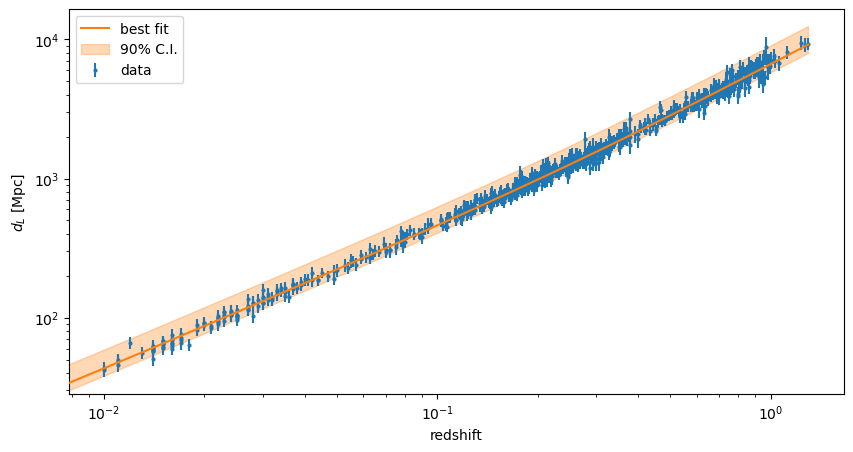

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

dl_unit = 'Mpc'
ax.errorbar(data.z, dl_meas.to(dl_unit).value, yerr=edl_meas.to(dl_unit).value, 
            ls='', marker='o', capsize=0, ms=2, label='data')
ax.plot(z_plot, dl_model, label='best fit', color='C1', zorder=5)
ax.fill_between(z_plot, y1=errors.T[0], y2=errors.T[1], alpha=0.3, color='C1', label=f'{cl*100:.0f}% C.I.')

ax.set_ylabel(f'$d_L$ [{dl_unit}]')
ax.set_xlabel('redshift')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.show()
plt.close()

Now we are obviously also interested in the parameter distributions. The module `corner` let's us easily plot those. The title of the one dimensional distributions show the median value and the 90% confidence interval.

In [26]:
import corner

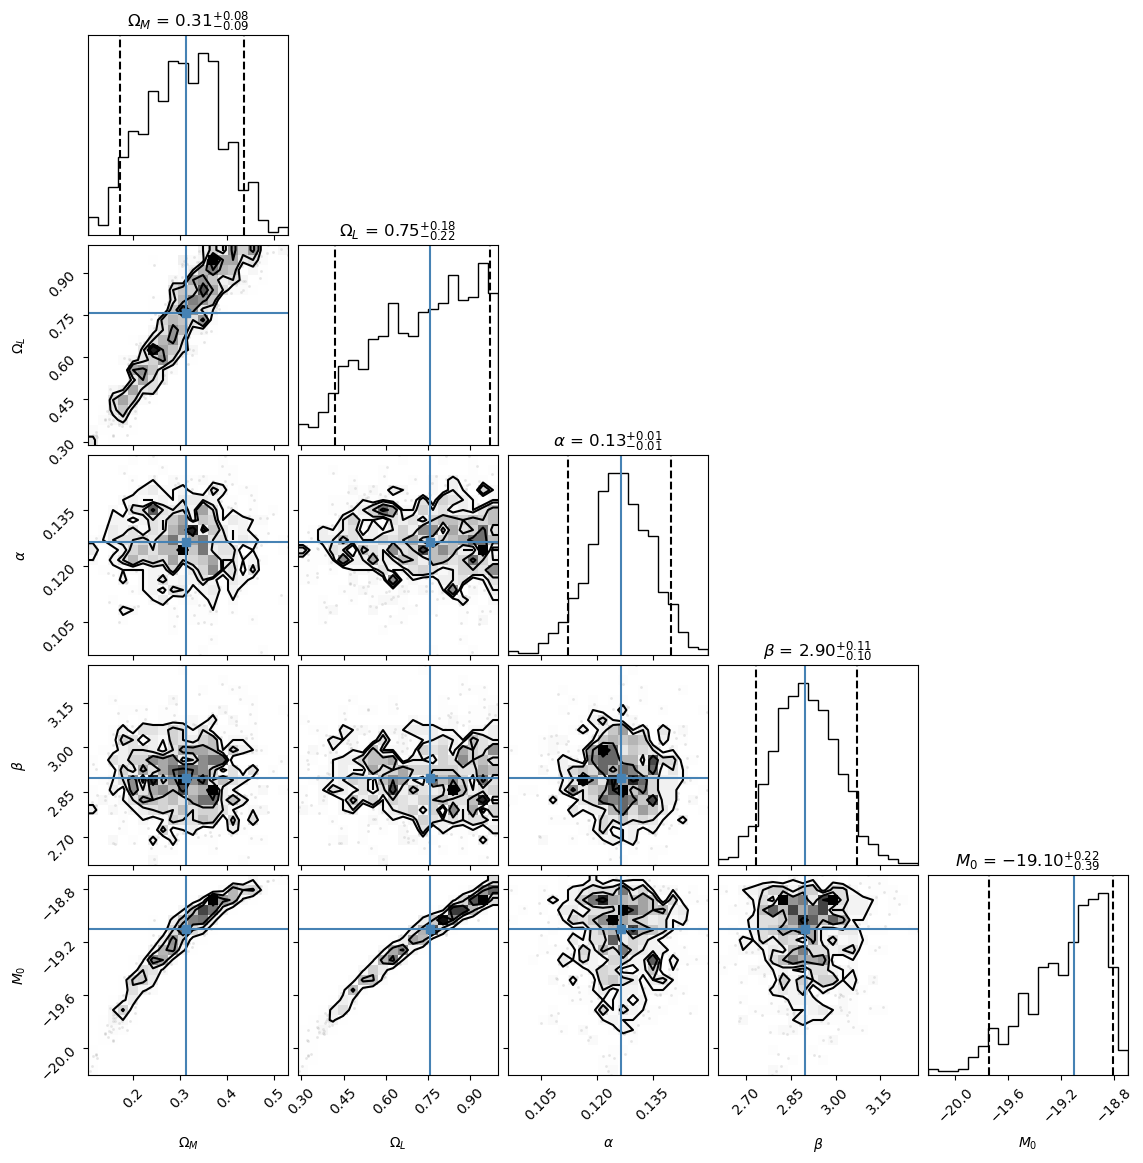

In [27]:
fig = corner.corner(
    flat_samples, labels=labels, 
    truths=best_fit.x, 
    quantiles=[0.05, 0.95],
    plot_contours=True,
    show_titles=True
)
plt.show()
plt.close()

You might notice that the contours in the ($\Omega_M$, $\Omega_\Lambda$) are indicating correlation instead of anti-correlation as we have seen in the plot we produced above. This is the effect of marginalisation. The likelihood space looks so different because we simultaniously vary the other parameters as well. Note the strong correlation of both $\Omega$s with $M_0$.

If we repeat the whole process but keep $\alpha$, $\beta$ and $M_0$ fixed, we get the same result as before:

In [28]:
alpha, beta, M0 = 0.15, 3, -19
sigma = 0.14
bounds_omegas = [(0, 1), (0, 1)]


def log_likelihood_omegas(theta):
    omega_M, omega_L = theta
    
    dl_meas, edl_meas = luminosity_distance_from_measurement(data, alpha, beta, M0, sigma=sigma)
    dl_model = luminosity_distance(data.z, omega_M, omega_L)
    
    residuals_squared = (dl_meas - dl_model) ** 2
    weights = edl_meas ** 2
    unit = 'Mpc 2'
    return 0.5 * np.sum(residuals_squared.to(unit).value / weights.to(unit).value)


def log_prior_omegas(theta):
    omega_M, omega_L = theta
    
    check_bounds = [
        b[0] < v < b[1] for v, b in zip(theta, bounds_omegas)
    ]
    
    if np.all(check_bounds):
        return 0.
    else:
        return -np.inf


def log_probability_omegas(theta):
    lp = log_prior_omegas(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - log_likelihood_omegas(theta)

In [29]:
best_fit_omegas = optimize.minimize(
    log_likelihood_omegas, 
    x0=[0.3, 0.7], 
    bounds=bounds_omegas
)

print("----- best fit parameters -----")
param_names = ['Omega_M', 'Omega_L']
for n, val in zip(param_names, best_fit_omegas.x):
    print(f"\t{n:<7} = {val:.2f}")

----- best fit parameters -----
	Omega_M = 0.33
	Omega_L = 0.85


In [30]:
filename = "exercise3_3_mcmc.h5"
backend2 = emcee.backends.HDFBackend(filename, name='mcmc_fixed_nuisance_params')
COMPUTE = False

if COMPUTE:
    pos = best_fit_omegas.x + 1e-4 * np.random.randn(8, 2)
    nwalkers, ndim = pos.shape

    max_n = 10000
    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf

    move = emcee.moves.StretchMove(a=80.0)

    with mp.Pool(9) as p:
        backend2.reset(nwalkers, ndim)
        sampler2 = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability_omegas, pool=p, backend=backend2, moves=move
        )

        # Now we'll sample for up to max_n steps
        thin_by = 50
        for sample in sampler2.sample(pos, iterations=max_n, progress=True, tune=True, thin_by=thin_by):
            # Only check convergence every 100 steps
            if sampler2.iteration % (100/thin_by):
                continue

            # Compute the autocorrelation time so far
            # Using tol=0 means that we'll always get an estimate even
            # if it isn't trustworthy
            tau = sampler2.get_autocorr_time(tol=0)
            autocorr[index] = np.mean(tau)
            index += 1

            # Check convergence
            eps = np.abs(old_tau - tau) / tau
            if not sampler2.iteration % (1000/thin_by):
                # every 1000 steps print the improvement of tau
                print('median tau improvement :', np.median(eps))
                print('median tau: ', np.median(tau))

            converged = np.all(tau * 100 < sampler2.iteration)
            converged &= np.all(eps < 0.01)
            if converged:
                break
            old_tau = tau
            
else:
    sampler2 = backend2
    ndim = 2

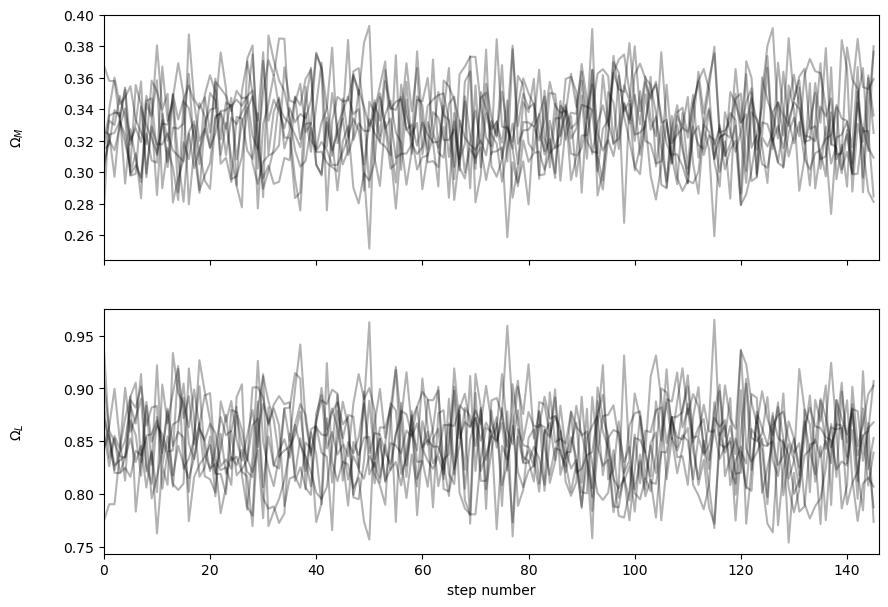

In [31]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler2.get_chain()
labels = ["$\Omega_M$", "$\Omega_L$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

plt.show()
plt.close()

In [32]:
tau = sampler2.get_autocorr_time()

for l, t in zip(param_names, tau):
    print(f"{l}'s tau: {t:.2f}")

Omega_M's tau: 1.31
Omega_L's tau: 1.32


Now we do not get an error message because our chain is long enough. We will now discard the first 10 steps and keep every 2nd step

In [33]:
flat_samples = sampler2.get_chain(discard=10, thin=2, flat=True)

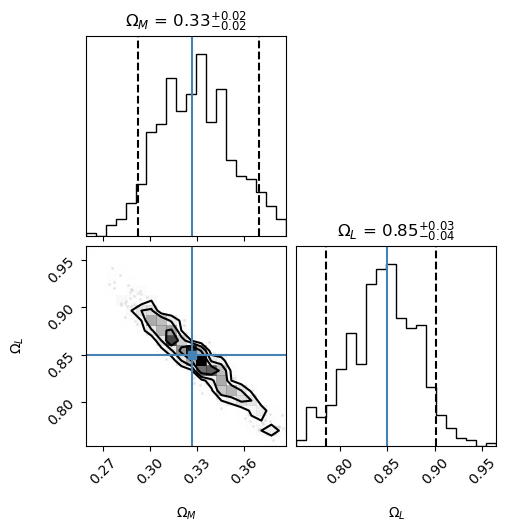

In [34]:
fig = corner.corner(
    flat_samples, labels=labels, 
    truths=best_fit_omegas.x, 
    quantiles=[0.05, 0.95],
    plot_contours=True,
    show_titles=True
)
plt.show()
plt.close()

This does look a lot like the un-marginalised likelihood contours we plotted earlier!